In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-08 11:30:09.292323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 11:30:10.586172: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [14]:
start_idx = 16700+100
end_idx = 17000-50
duration = end_idx - start_idx

In [15]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(150, 96)

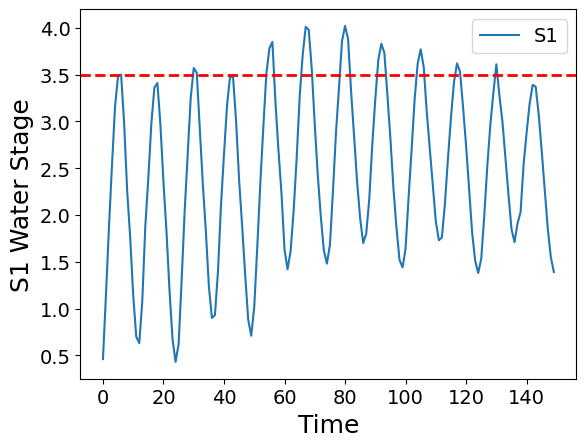

In [16]:
plt.plot(ws1[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Get optimizable and not optimizable variables

In [17]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [18]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(150, 96, 7)
(100800,)


In [19]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(150, 96, 2)


In [20]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(150, 96, 3)


### GA

In [21]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv}, compile=False)
# load_model('cnn.h5', compile=False)

2023-08-08 11:30:25.891806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


In [22]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    
#     # test_ws_y
#     test_ws_y_target = test_ws_y[start_idx:end_idx]
#     ws_penalty_sum1 = 0
#     for i in range(duration):
#         for j in range(96):
#             penalty_ws1 = np.abs(yhat[i, j] - test_ws_y_target[i, j])**2
            
#             ws_penalty_sum1 += penalty_ws1
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [23]:
fitness_function = fitness_func

num_generations = 500
num_parents_mating = 32

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [24]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [25]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-08 11:30:36.498217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 3ms/step
CPU time: 10385.198949559825 seconds


In [26]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

5/5 [==============================] - 0s 3ms/step
Parameters of the best solution : [0.33263744 0.09865326 0.45787967 ... 0.04672895 0.58702123 0.37036825]
Fitness value of the best solution = 4.7249367611159e-05


### Post-processing

In [27]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

5/5 [==============================] - 0s 3ms/step


In [28]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

2303


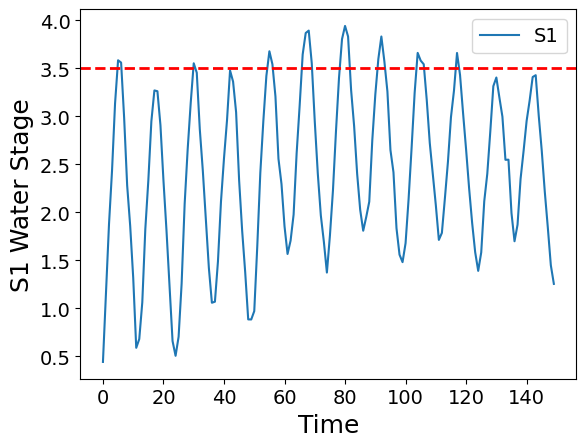

In [29]:
plt.plot(best_perf[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [30]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event4.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.332637,0.098653,0.457880,0.141229,0.567936,0.606320,0.488494,0.944550,0.264368,0.431544,...,0.117864,0.750140,0.548912,0.538175,0.532505,0.163167,0.679212,0.607658,0.662727,0.530604
1,0.263650,0.226544,0.533450,0.167407,0.678247,0.620285,0.353473,0.020743,0.412345,0.801005,...,0.248075,0.674970,0.835991,0.143665,0.825564,0.047672,0.493555,0.772946,0.855572,0.004113
2,0.783622,0.169645,0.182328,0.605771,0.247062,0.540666,0.699158,0.842933,0.611478,0.667778,...,0.600327,0.005327,0.018650,0.656179,0.706054,0.707919,0.203881,0.479940,0.119398,0.365324
3,0.933265,0.031225,0.057165,0.125062,0.412968,0.461908,0.671073,0.866288,0.036095,0.312070,...,0.447324,0.855857,0.689643,0.636823,0.124737,0.230919,0.568272,0.723745,0.859134,0.008272
4,0.507176,0.041580,0.718961,0.103695,0.297264,0.004296,0.748945,0.325545,0.821674,0.433979,...,0.765849,0.046049,0.747426,0.445182,0.439223,0.872158,0.573466,0.668873,0.135947,0.664779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.970450,0.986898,0.403796,0.883748,0.236303,0.860929,0.817178,0.310845,0.734708,0.747114,...,0.395945,0.289906,0.487783,0.709165,0.297928,0.586094,0.209420,0.386278,0.098376,0.089131
146,0.654866,0.893209,0.965774,0.107645,0.044872,0.285162,0.613654,0.633507,0.921140,0.170357,...,0.219822,0.063092,0.554482,0.975211,0.531845,0.893662,0.087333,0.082927,0.906950,0.899580
147,0.920973,0.251214,0.838792,0.179549,0.119163,0.744906,0.014356,0.090697,0.062895,0.163597,...,0.427765,0.303468,0.315947,0.276087,0.557693,0.037501,0.329017,0.208566,0.494890,0.880610
148,0.997950,0.317560,0.845255,0.324220,0.693193,0.992364,0.998916,0.769795,0.689015,0.202488,...,0.183638,0.898686,0.895618,0.271750,0.975752,0.135869,0.647860,0.452499,0.257135,0.863726


In [31]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event4.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.443275,0.339824,0.590869,0.478441,1.184079,1.244257,1.175908,1.157651,1.976229,1.637426,...,2.072293,2.179982,1.154472,1.331219,1.383733,1.479801,0.624692,0.851480,0.863769,0.894649
1,1.151390,1.318941,1.169491,1.171502,1.911288,1.992000,1.906723,1.891928,2.715353,2.684511,...,1.532685,1.481683,0.804577,0.752144,1.090943,1.025551,0.424642,0.408484,0.646783,0.583830
2,1.876855,2.009463,1.955108,1.941900,2.458908,2.558921,2.465382,2.472433,3.181499,3.347255,...,0.940219,0.880074,0.432647,0.760156,0.682028,0.537168,0.620494,0.791968,0.848424,0.773673
3,2.433493,2.298999,2.464836,2.468854,3.174905,3.256787,3.136899,3.221422,3.559391,3.317324,...,0.478109,0.380661,0.694356,1.037879,0.900070,0.821507,1.200115,1.341068,1.292291,1.313834
4,3.133085,3.156873,3.272983,3.302124,3.461588,3.347754,3.467669,3.526470,3.597830,3.643363,...,0.823891,0.676596,1.289500,1.589082,1.550595,1.451319,2.005383,2.136495,2.186455,2.177595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2.641659,2.644021,2.668858,2.627476,2.316191,2.466920,2.403123,2.401741,1.806666,2.133350,...,2.833054,2.965450,3.163798,3.252883,3.122782,3.247798,3.157931,3.364086,3.231102,3.257318
146,2.215974,2.485596,2.252787,2.265915,2.014602,1.977570,2.157942,2.117402,1.562236,1.500885,...,3.035434,3.227785,3.122226,3.272079,3.164784,3.275347,2.932107,3.293018,3.113897,3.181061
147,1.843597,2.002801,1.913833,1.958810,1.716706,1.525956,1.801055,1.880690,1.443871,1.229715,...,3.168778,3.315652,2.825121,2.901378,2.832769,2.955254,2.374630,2.369263,2.379005,2.517537
148,1.449396,1.438384,1.628573,1.511755,1.407716,1.325667,1.523389,1.466195,1.519839,1.560664,...,2.808691,2.953887,2.442248,2.476027,2.525157,2.605078,1.968325,2.015465,2.166496,2.170080


In [32]:
Optimal_case = pd.read_csv("GA_results/best_performance_event4.csv")
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.443275,0.339824,0.590869,0.478441,1.184079,1.244257,1.175908,1.157651,1.976229,1.637426,...,2.072293,2.179982,1.154472,1.331219,1.383733,1.479801,0.624692,0.851480,0.863769,0.894649
1,1.151390,1.318941,1.169491,1.171502,1.911288,1.992000,1.906723,1.891928,2.715353,2.684511,...,1.532685,1.481683,0.804577,0.752143,1.090943,1.025551,0.424642,0.408484,0.646783,0.583830
2,1.876855,2.009463,1.955108,1.941900,2.458908,2.558921,2.465382,2.472433,3.181500,3.347255,...,0.940219,0.880074,0.432647,0.760156,0.682028,0.537168,0.620494,0.791968,0.848424,0.773673
3,2.433493,2.298999,2.464836,2.468854,3.174905,3.256787,3.136899,3.221422,3.559391,3.317324,...,0.478109,0.380661,0.694356,1.037879,0.900070,0.821507,1.200115,1.341068,1.292291,1.313834
4,3.133085,3.156873,3.272983,3.302124,3.461588,3.347754,3.467669,3.526470,3.597830,3.643363,...,0.823891,0.676596,1.289500,1.589082,1.550595,1.451319,2.005383,2.136495,2.186455,2.177595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2.641659,2.644021,2.668858,2.627476,2.316191,2.466920,2.403123,2.401741,1.806666,2.133350,...,2.833054,2.965450,3.163798,3.252883,3.122781,3.247798,3.157931,3.364086,3.231102,3.257318
146,2.215974,2.485596,2.252787,2.265915,2.014602,1.977570,2.157942,2.117402,1.562236,1.500885,...,3.035435,3.227785,3.122226,3.272079,3.164784,3.275348,2.932107,3.293018,3.113897,3.181061
147,1.843597,2.002801,1.913833,1.958810,1.716706,1.525956,1.801055,1.880689,1.443871,1.229715,...,3.168778,3.315652,2.825121,2.901378,2.832769,2.955254,2.374630,2.369263,2.379005,2.517537
148,1.449396,1.438384,1.628573,1.511755,1.407716,1.325667,1.523389,1.466195,1.519839,1.560664,...,2.808690,2.953887,2.442248,2.476027,2.525157,2.605078,1.968325,2.015465,2.166496,2.170080


In [33]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 2303, areas: 601.9729522999972
time steps: 0, areas: 0


In [34]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

5/5 [==============================] - 0s 3ms/step
time steps: 2097, areas: 493.8645911216736
time steps: 0, areas: 0
